# **DATA COLLECTION**

In [1]:
import requests
import pandas as pd
import logging
from datetime import datetime, timedelta, date
from pathlib import Path

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

cities = {
    'Karachi': {'lat': 24.8607, 'lon': 67.0011},
    'Islamabad': {'lat': 33.6844, 'lon': 73.0479},
    'Lahore': {'lat': 31.558, 'lon': 74.3507}
}

API_KEY_AIR = 'your-api-key'

# Set a static date range (January 1, 2024 to December 31, 2024)
start_date = '2024-01-01'
end_date = '2024-12-31'

def fetch_historical_weather(city, coords, start_date, end_date):
    """Fetch historical weather data for the given date range"""
    url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={coords['lat']}&longitude={coords['lon']}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,"
        f"apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,"
        f"sunrise,sunset,wind_speed_10m_max,wind_gusts_10m_max,"
        f"wind_direction_10m_dominant,shortwave_radiation_sum"
        f"&timezone=Asia/Karachi"
    )
    
    logging.info(f"Fetching historical weather for {city} from {start_date} to {end_date}")
    response = requests.get(url)
    return response

def fetch_current_weather(city, coords):
    """Fetch current day's weather data"""
    today = datetime.now().date()
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={coords['lat']}&longitude={coords['lon']}"
        f"&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,"
        f"apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,"
        f"sunrise,sunset,wind_speed_10m_max,wind_gusts_10m_max,"
        f"wind_direction_10m_dominant,shortwave_radiation_sum"
        f"&timezone=Asia/Karachi"
    )
    
    logging.info(f"Fetching current weather for {city} for {today}")
    response = requests.get(url)
    return response

def process_weather_response(city, response, weather_data):
    """Process weather API response and add to weather_data list"""
    if response.status_code == 200:
        data = response.json()
        for i, day in enumerate(data['daily']['time']):
            weather_data.append({
                'City': city,
                'Date': pd.to_datetime(day).date(),
                'Max Temp (°C)': data['daily']['temperature_2m_max'][i],
                'Min Temp (°C)': data['daily']['temperature_2m_min'][i],
                'Mean Temp (°C)': data['daily']['temperature_2m_mean'][i],
                'Max Apparent Temp (°C)': data['daily']['apparent_temperature_max'][i],
                'Min Apparent Temp (°C)': data['daily']['apparent_temperature_min'][i],
                'Mean Apparent Temp (°C)': data['daily']['apparent_temperature_mean'][i],
                'Sunrise': data['daily']['sunrise'][i],
                'Sunset': data['daily']['sunset'][i],
                'Max Wind Speed (10m) (km/h)': data['daily']['wind_speed_10m_max'][i],
                'Max Wind Gusts (10m) (km/h)': data['daily']['wind_gusts_10m_max'][i],
                'Dominant Wind Direction (°)': data['daily']['wind_direction_10m_dominant'][i],
                'Shortwave Radiation Sum (MJ/m²)': data['daily']['shortwave_radiation_sum'][i],
            })
    else:
        logging.error(f"Error fetching weather data for {city}: {response.status_code}")
        logging.error(f"Response: {response.text}")

def fetch_weather_data():
    """Fetch both historical and current weather data"""
    all_weather_data = []
    
    for city, coords in cities.items():
        # Fetch historical data from January 1, 2024 to December 31, 2024
        historical_response = fetch_historical_weather(city, coords, start_date, end_date)
        process_weather_response(city, historical_response, all_weather_data)
        
        # Fetch current/forecast data for today (if desired)
        current_response = fetch_current_weather(city, coords)
        process_weather_response(city, current_response, all_weather_data)
    
    weather_df = pd.DataFrame(all_weather_data)
    
    if not weather_df.empty:
        # Remove any duplicate dates that might occur due to overlap
        weather_df = weather_df.drop_duplicates(subset=['City', 'Date'], keep='last')
        # Sort the data
        weather_df = weather_df.sort_values(['City', 'Date'])
        
        logging.info(f"Weather data collected: {len(weather_df)} records")
        logging.info(f"Date range: {weather_df['Date'].min()} to {weather_df['Date'].max()}")
        logging.info(f"Cities: {weather_df['City'].unique()}")
        logging.info(f"Records per city:\n{weather_df['City'].value_counts()}")
    else:
        logging.error("No weather data collected!")
    
    return weather_df

def fetch_air_pollution_data():
    """Fetch and aggregate air pollution data, including AQI"""
    all_air_pollution_data = []
    
    for city, coords in cities.items():
        start_timestamp = int(datetime.combine(datetime.strptime(start_date, '%Y-%m-%d'), datetime.min.time()).timestamp())
        end_timestamp = int(datetime.combine(datetime.strptime(end_date, '%Y-%m-%d'), datetime.max.time()).timestamp())
        
        url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={coords['lat']}&lon={coords['lon']}&start={start_timestamp}&end={end_timestamp}&appid={API_KEY_AIR}"
        
        logging.info(f"Fetching air pollution data for {city}")
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            
            # Group records by date
            daily_records = {}
            for record in data['list']:
                record_date = datetime.utcfromtimestamp(record['dt']).date()
                if record_date not in daily_records:
                    daily_records[record_date] = {
                        'components': [],
                        'aqi': []  # Store AQI values separately
                    }
                daily_records[record_date]['components'].append(record['components'])
                daily_records[record_date]['aqi'].append(float(record['main']['aqi']))  # Convert to float
            
            # Calculate daily averages
            for record_date, records in daily_records.items():
                components = records['components']
                avg_components = {
                    'pm10': sum(r.get('pm10', 0) for r in components) / len(components),
                    'pm2_5': sum(r.get('pm2_5', 0) for r in components) / len(components),
                    'no': sum(r.get('no', 0) for r in components) / len(components),
                    'no2': sum(r.get('no2', 0) for r in components) / len(components),
                    'o3': sum(r.get('o3', 0) for r in components) / len(components),
                    'so2': sum(r.get('so2', 0) for r in components) / len(components),
                    'co': sum(r.get('co', 0) for r in components) / len(components),
                    'nh3': sum(r.get('nh3', 0) for r in components) / len(components)
                }
                
                # Calculate daily average AQI as float
                avg_aqi = sum(records['aqi']) / len(records['aqi'])
                
                all_air_pollution_data.append({
                    'City': city,
                    'Date': record_date,
                    'PM10': avg_components['pm10'],
                    'PM2.5': avg_components['pm2_5'],
                    'NO': avg_components['no'],
                    'NO2': avg_components['no2'],
                    'O3': avg_components['o3'],
                    'SO2': avg_components['so2'],
                    'CO': avg_components['co'],
                    'NH3': avg_components['nh3'],
                    'AQI': avg_aqi  # No longer rounded to integer
                })
        else:
            logging.error(f"Error fetching air pollution data for {city}: {response.status_code}")
            logging.error(f"Response: {response.text}")
    
    air_pollution_df = pd.DataFrame(all_air_pollution_data)
    
    if not air_pollution_df.empty:
        air_pollution_df = air_pollution_df.sort_values(['City', 'Date'])
        logging.info(f"Air pollution data collected: {len(air_pollution_df)} records")
        logging.info(f"Date range: {air_pollution_df['Date'].min()} to {air_pollution_df['Date'].max()}")
        logging.info(f"Cities: {air_pollution_df['City'].unique()}")
    else:
        logging.error("No air pollution data collected!")
    
    return air_pollution_df

def merge_datasets(weather_df, air_pollution_df):
    """Merge weather and air pollution datasets"""
    if weather_df.empty or air_pollution_df.empty:
        logging.error("One or both datasets are empty!")
        return pd.DataFrame()
    
    merged_df = pd.merge(
        weather_df,
        air_pollution_df,
        on=['City', 'Date'],
        how='inner'
    )
    
    merged_df = merged_df.sort_values(['City', 'Date'])
    
    if not merged_df.empty:
        logging.info(f"Merged data shape: {merged_df.shape}")
        logging.info(f"Final date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
        logging.info(f"Cities in final dataset: {merged_df['City'].unique()}")
        logging.info(f"Records per city:\n{merged_df['City'].value_counts()}")
    
    return merged_df

def main():
    logging.info(f"Collecting data from {start_date} to {end_date}")
    
    # Fetch weather data
    weather_df = fetch_weather_data()
    
    # Fetch air pollution data
    air_pollution_df = fetch_air_pollution_data()
    
    # Merge the datasets
    merged_df = merge_datasets(weather_df, air_pollution_df)
    
    # Only save the merged dataset to CSV
    if not merged_df.empty:
        merged_df.to_csv('combined_data.csv', index=False)
        logging.info("Successfully saved combined data")
    else:
        logging.error("Failed to create combined dataset!")
    
    return merged_df

if __name__ == "__main__":
    main()


2025-01-23 13:21:23,888 - INFO - Collecting data from 2024-01-01 to 2024-12-31
2025-01-23 13:21:23,890 - INFO - Fetching historical weather for Karachi from 2024-01-01 to 2024-12-31
2025-01-23 13:21:25,140 - INFO - Fetching current weather for Karachi for 2025-01-23
2025-01-23 13:21:25,889 - INFO - Fetching historical weather for Islamabad from 2024-01-01 to 2024-12-31
2025-01-23 13:21:27,508 - INFO - Fetching current weather for Islamabad for 2025-01-23
2025-01-23 13:21:28,217 - INFO - Fetching historical weather for Lahore from 2024-01-01 to 2024-12-31
2025-01-23 13:21:29,251 - INFO - Fetching current weather for Lahore for 2025-01-23
2025-01-23 13:21:30,008 - INFO - Weather data collected: 1119 records
2025-01-23 13:21:30,013 - INFO - Date range: 2024-01-01 to 2025-01-29
2025-01-23 13:21:30,016 - INFO - Cities: ['Islamabad' 'Karachi' 'Lahore']
2025-01-23 13:21:30,022 - INFO - Records per city:
City
Islamabad    373
Karachi      373
Lahore       373
Name: count, dtype: int64
2025-01-

In [2]:
# Import necessary libraries for data analysis and visualization

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For handling warnings
import warnings
warnings.filterwarnings("ignore")

# Display settings for pandas (optional)
pd.set_option('display.max_columns', None)  # Show all columns in the dataframe
pd.set_option('display.width', 1000)  # Increase width to avoid truncated output


**Load the data**

In [3]:
# Load the dataset into a pandas DataFrame
file_path = 'combined_data.csv'  # Ensure the file is in the correct directory

# Load the data into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to inspect its structure
print(data.head())


        City        Date  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Max Apparent Temp (°C)  Min Apparent Temp (°C)  Mean Apparent Temp (°C)           Sunrise            Sunset  Max Wind Speed (10m) (km/h)  Max Wind Gusts (10m) (km/h)  Dominant Wind Direction (°)  Shortwave Radiation Sum (MJ/m²)        PM10       PM2.5          NO         NO2         O3        SO2           CO        NH3  AQI
0  Islamabad  2024-01-01           16.3            8.6            13.3                    14.2                     6.3                     11.5  2024-01-01T07:12  2024-01-01T17:10                         11.9                         24.1                          341                            10.49  366.851250  322.745417   58.752500  112.471250  21.003750  25.317083  4813.193750  51.820000  5.0
1  Islamabad  2024-01-02           15.8            7.9            12.3                    15.0                     6.1                     10.9  2024-01-02T07:13  2024-01-02T17:10                       

In [4]:
# Check the general information of the dataset
data_info = data.info()

# Display the summary of the dataset
data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   City                             1097 non-null   object 
 1   Date                             1097 non-null   object 
 2   Max Temp (°C)                    1097 non-null   float64
 3   Min Temp (°C)                    1097 non-null   float64
 4   Mean Temp (°C)                   1097 non-null   float64
 5   Max Apparent Temp (°C)           1097 non-null   float64
 6   Min Apparent Temp (°C)           1097 non-null   float64
 7   Mean Apparent Temp (°C)          1097 non-null   float64
 8   Sunrise                          1097 non-null   object 
 9   Sunset                           1097 non-null   object 
 10  Max Wind Speed (10m) (km/h)      1097 non-null   float64
 11  Max Wind Gusts (10m) (km/h)      1097 non-null   float64
 12  Dominant Wind Direct

In [5]:
# Checking for missing values in the dataset
missing_data = data.isnull().sum()

# Displaying columns with missing data and their count
missing_data[missing_data > 0]


Series([], dtype: int64)

In [6]:
# Generating basic statistics for numerical columns
descriptive_stats = data.describe()

# Display the descriptive statistics
descriptive_stats


,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Max Apparent Temp (°C),Min Apparent Temp (°C),Mean Apparent Temp (°C),Max Wind Speed (10m) (km/h),Max Wind Gusts (10m) (km/h),Dominant Wind Direction (°),Shortwave Radiation Sum (MJ/m²),PM10,PM2.5,NO,NO2,O3,SO2,CO,NH3,AQI
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,29.012124,19.597539,24.012762,30.384230,20.411212,25.147220,17.372926,32.023974,217.690975,17.436718,156.924650,119.127008,17.760193,52.250072,59.678773,15.478444,2155.586804,21.924503,4.066406
std,7.164844,7.504250,7.234169,9.217958,10.030443,9.431533,7.429414,11.133400,110.502775,5.127874,141.867577,125.933881,23.061056,50.622625,27.665188,11.275301,1656.283933,17.824811,0.884312
min,11.900000,2.700000,6.600000,9.900000,-0.200000,4.900000,3.900000,9.700000,0.000000,1.820000,-310.641667,6.595000,0.000000,-413.992917,0.000000,1.032500,230.310000,0.000000,1.291667
25%,24.500000,14.100000,18.900000,23.400000,11.900000,17.700000,11.500000,23.400000,109.000000,13.740000,62.967083,35.968333,1.420417,23.790833,39.080000,7.870000,908.870833,9.002083,3.375000
50%,30.800000,21.900000,25.900000,32.900000,22.200000,27.400000,16.100000,31.000000,258.000000,17.890000,108.264167,74.178333,8.879167,49.808333,57.282083,13.187917,1749.316667,18.379583,4.250000
75%,33.700000,25.900000,29.500000,37.700000,29.600000,33.200000,22.800000,40.000000,320.000000,21.390000,202.153333,150.850833,23.657500,74.478750,77.112083,20.414583,2922.297083,30.983750,4.916667
max,46.300000,31.800000,37.400000,46.400000,36.400000,39.900000,46.600000,74.500000,360.000000,27.910000,890.200000,791.119167,136.997500,195.660833,149.280417,81.817500,8113.225417,117.140000,5.000000


In [7]:
# Assuming your combined dataset is named 'combined_data'
df_cleaned = data.dropna()

# Verify if any missing values remain
missing_data_after_cleaning = df_cleaned.isnull().sum()

# Check the shape of the dataset after cleaning
print(f"Original dataset shape: {data.shape}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")

# Display the cleaned data info to ensure no missing values
df_cleaned.info()

# Optionally, we can also check for missing data in specific columns
print("\nMissing data after cleaning:")
print(missing_data_after_cleaning)


Original dataset shape: (1097, 23)
Cleaned dataset shape: (1097, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   City                             1097 non-null   object 
 1   Date                             1097 non-null   object 
 2   Max Temp (°C)                    1097 non-null   float64
 3   Min Temp (°C)                    1097 non-null   float64
 4   Mean Temp (°C)                   1097 non-null   float64
 5   Max Apparent Temp (°C)           1097 non-null   float64
 6   Min Apparent Temp (°C)           1097 non-null   float64
 7   Mean Apparent Temp (°C)          1097 non-null   float64
 8   Sunrise                          1097 non-null   object 
 9   Sunset                           1097 non-null   object 
 10  Max Wind Speed (10m) (km/h)      1097 non-null   float64
 11  Max Wind Gust

https://open-meteo.com/en/docs/historical-weather-api#latitude=31.558&longitude=74.3507&daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration


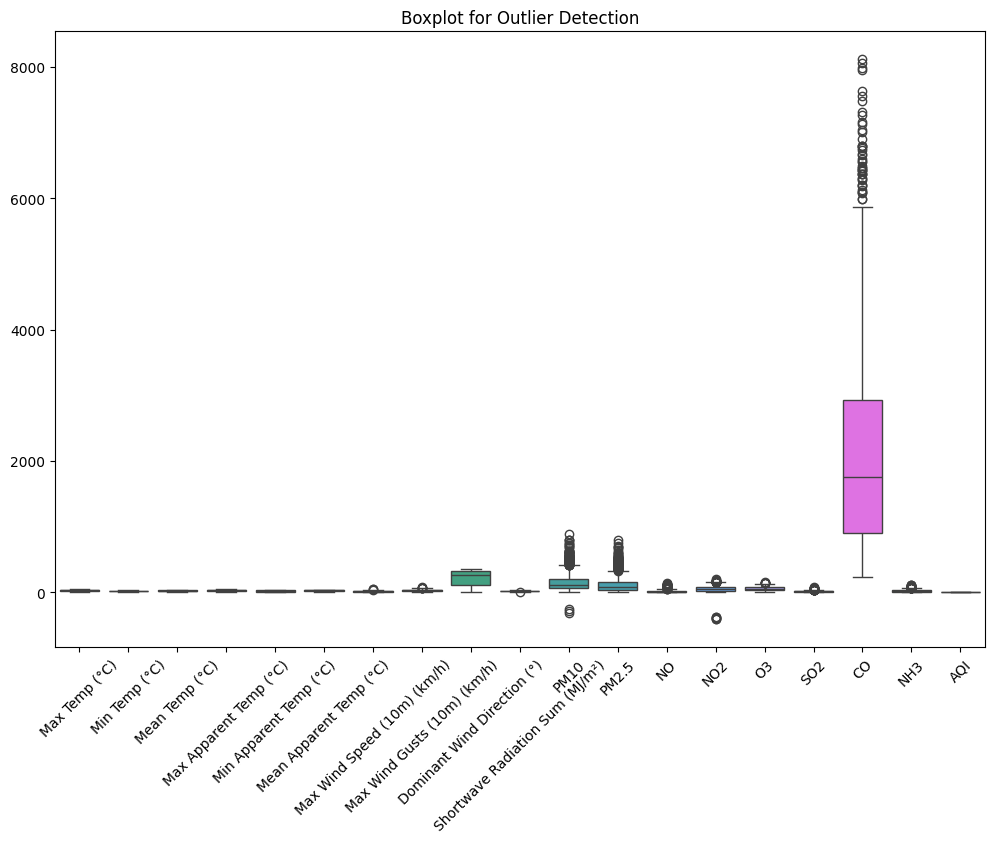

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical columns to inspect for outliers
numerical_columns = ['Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 
                     'Max Apparent Temp (°C)', 'Min Apparent Temp (°C)', 'Mean Apparent Temp (°C)',
                     'Max Wind Speed (10m) (km/h)', 'Max Wind Gusts (10m) (km/h)', 
                     'Dominant Wind Direction (°)', 'Shortwave Radiation Sum (MJ/m²)', 
                     'PM10', 'PM2.5', 'NO', 'NO2', 'O3', 'SO2', 'CO', 'NH3','AQI']

# Create boxplots to detect outliers in the numerical columns
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_columns])
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()


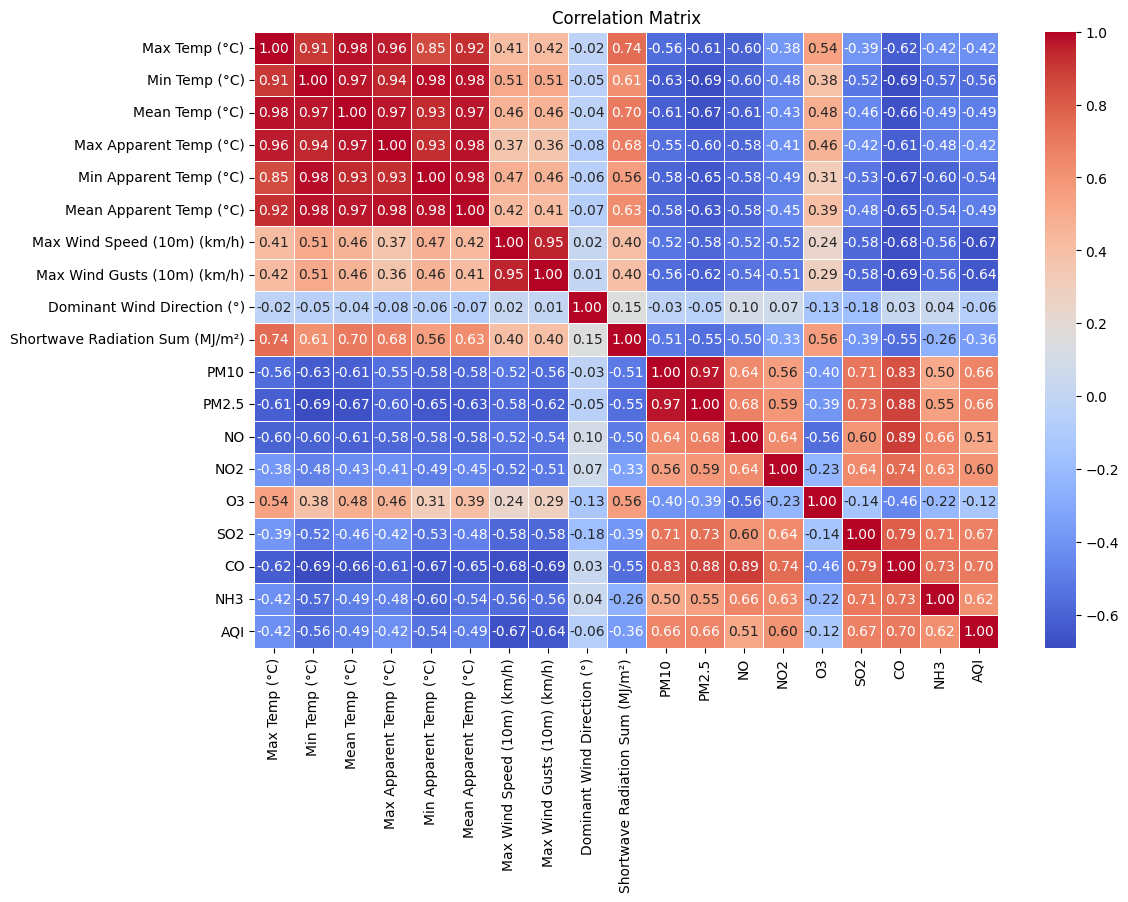

In [9]:
# Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


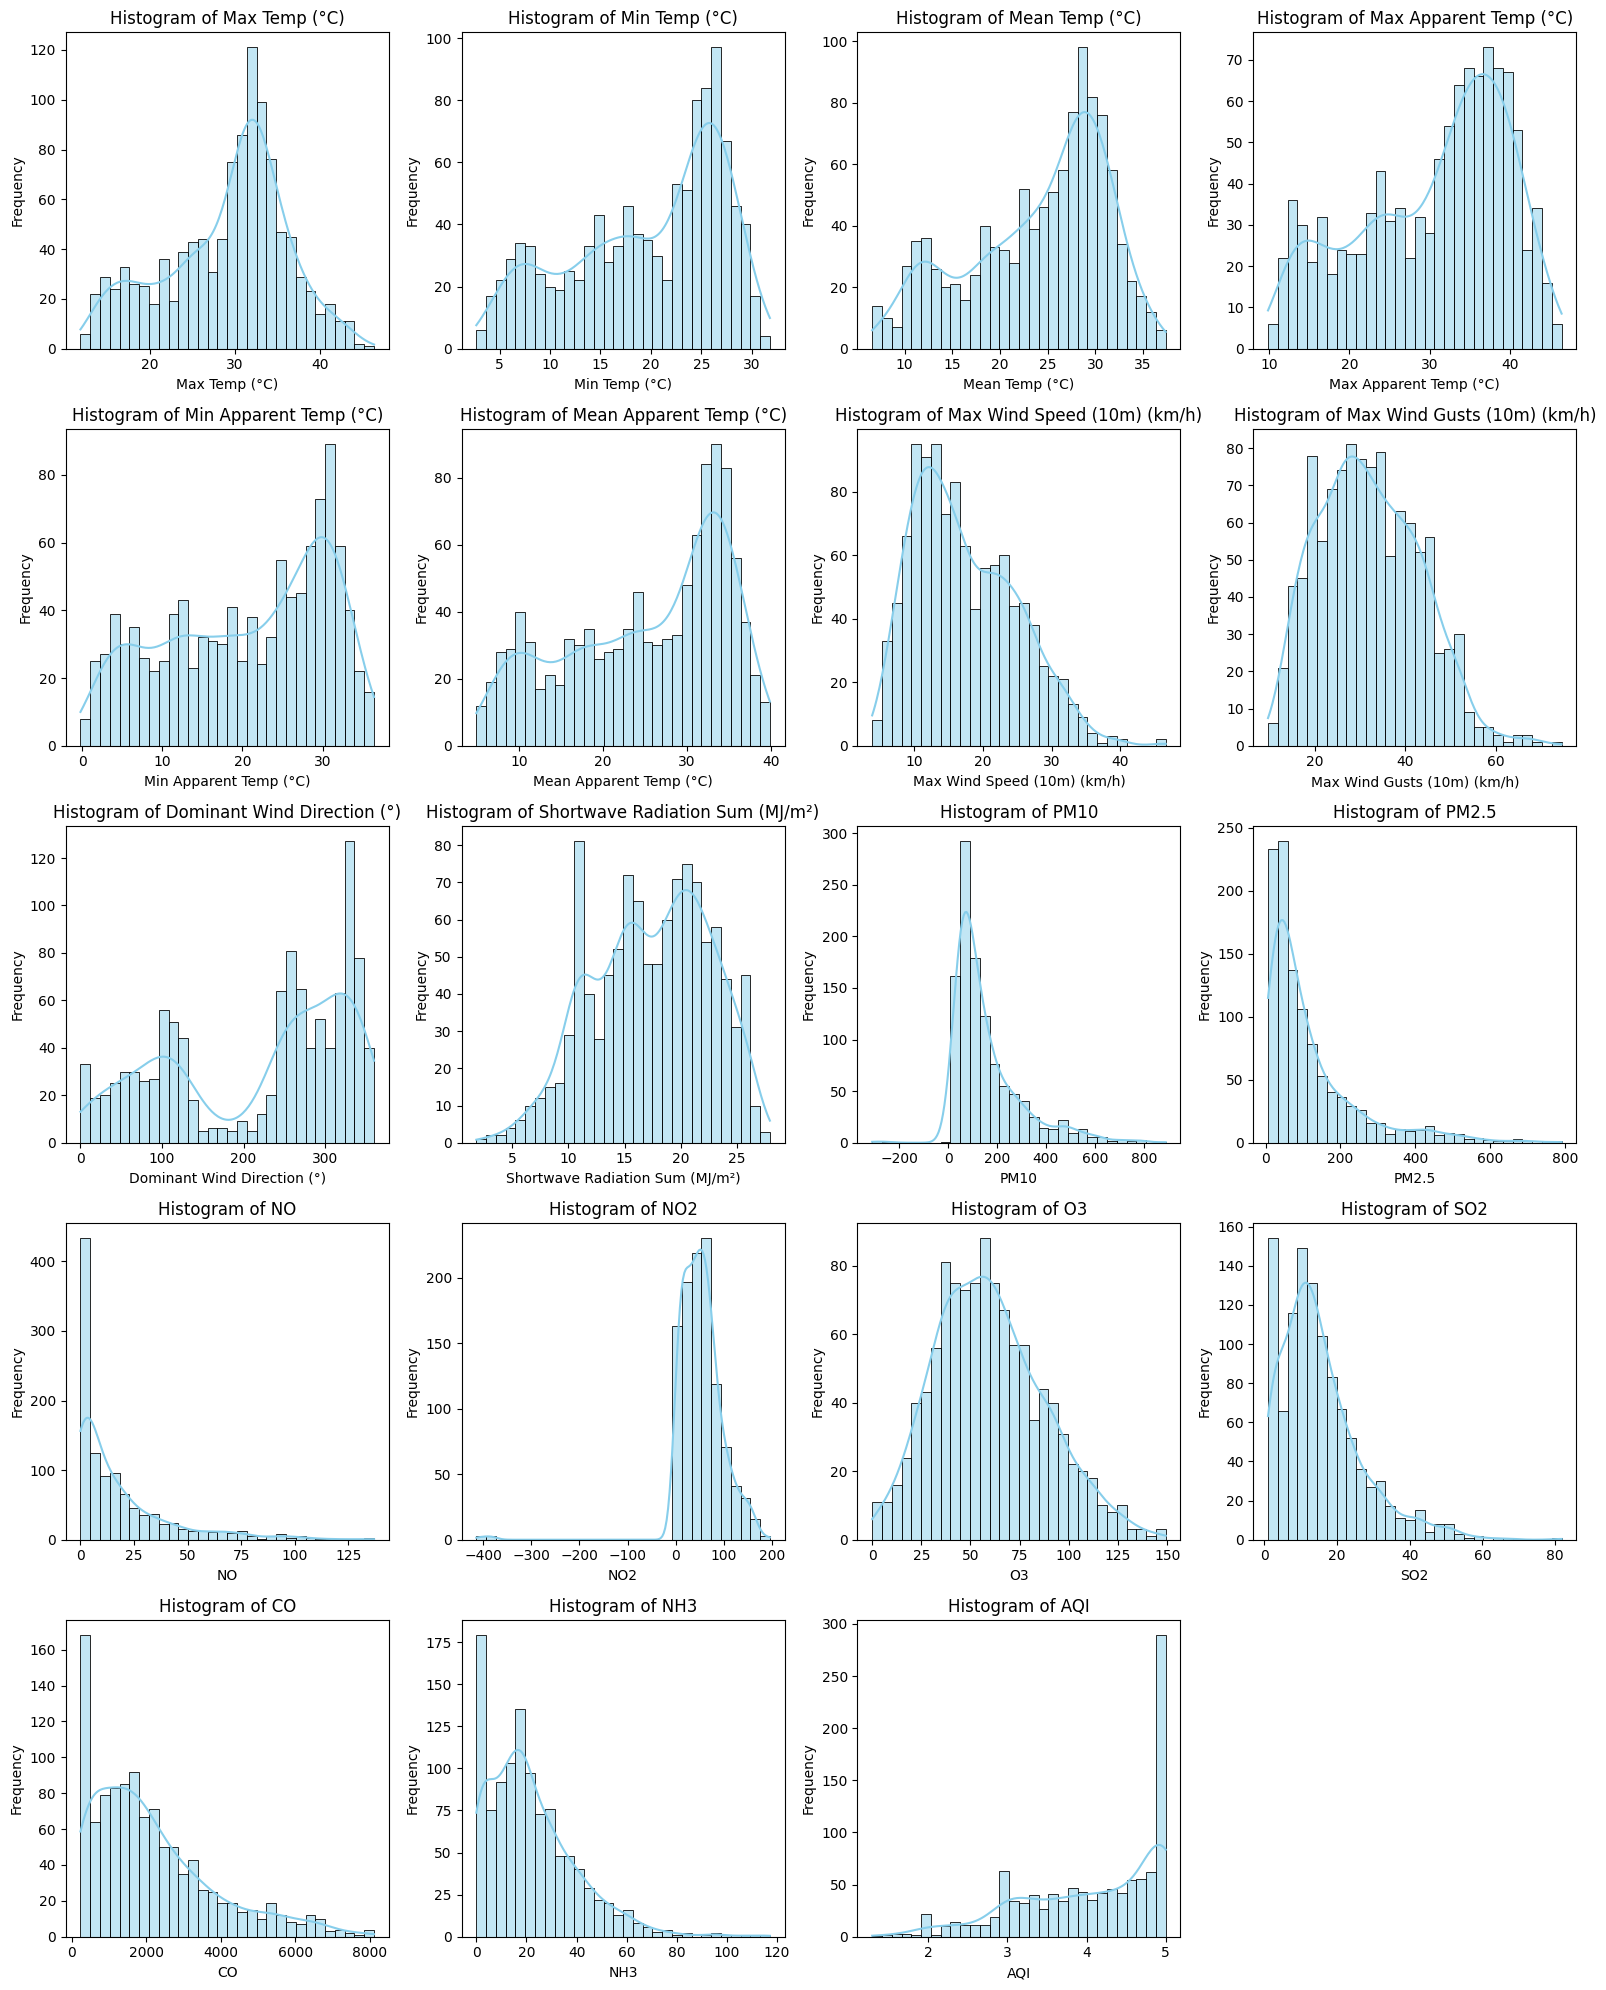

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows and columns needed for the subplots
num_columns = 4  # Number of columns in the subplot grid
num_rows = int(np.ceil(len(numerical_columns) / num_columns))  # Automatically calculate the number of rows

# Set up the plot size based on the number of rows and columns
plt.figure(figsize=(num_columns * 4, num_rows * 4))

# Create subplots for each numerical column
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_columns, i)  # Adjust the grid dynamically
    sns.histplot(data[column], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


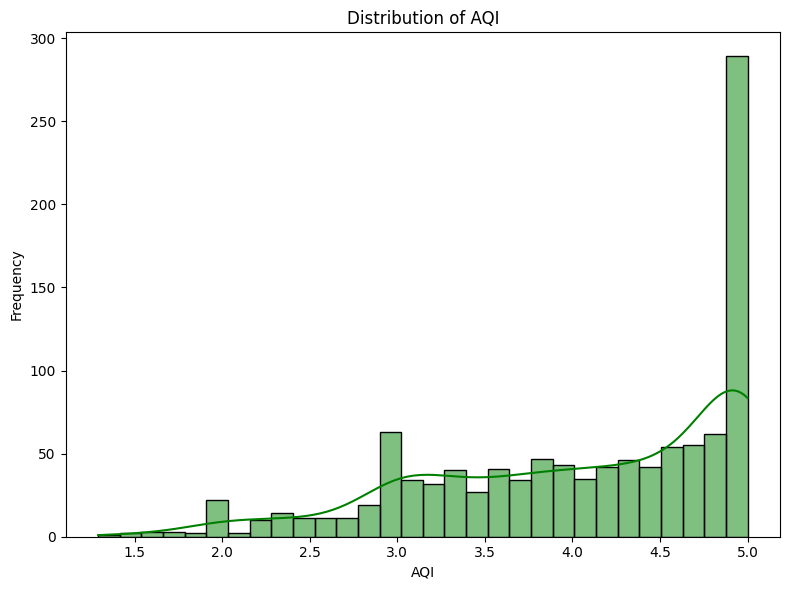

In [11]:
# Plot the distribution of AQI
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['AQI'], kde=True, color='green', bins=30, edgecolor='black')
plt.title('Distribution of AQI')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


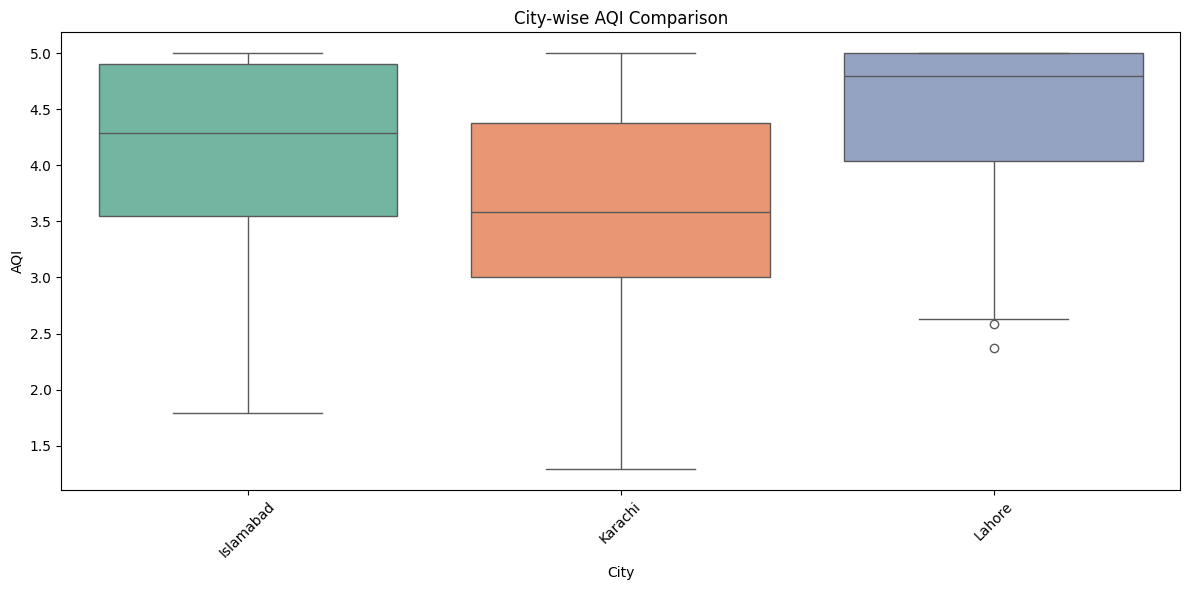

In [12]:
# Boxplot of AQI values by city
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='City', y='AQI', palette='Set2')
plt.title('City-wise AQI Comparison')
plt.xlabel('City')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


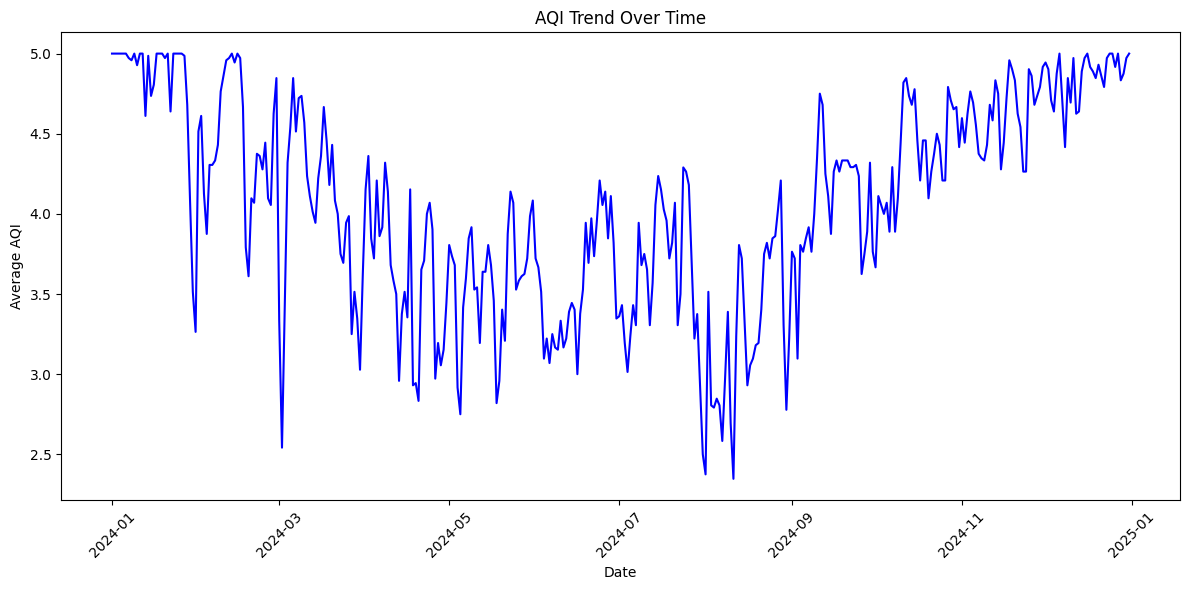

In [13]:
# Set the timestamp column as datetime (if not already)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Group by timestamp and calculate the mean AQI per day
df_time_series = df_cleaned.groupby(df_cleaned['Date'].dt.date)['AQI'].mean()

# Plot AQI over time
plt.figure(figsize=(12, 6))
plt.plot(df_time_series.index, df_time_series.values, color='blue')
plt.title('AQI Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average AQI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


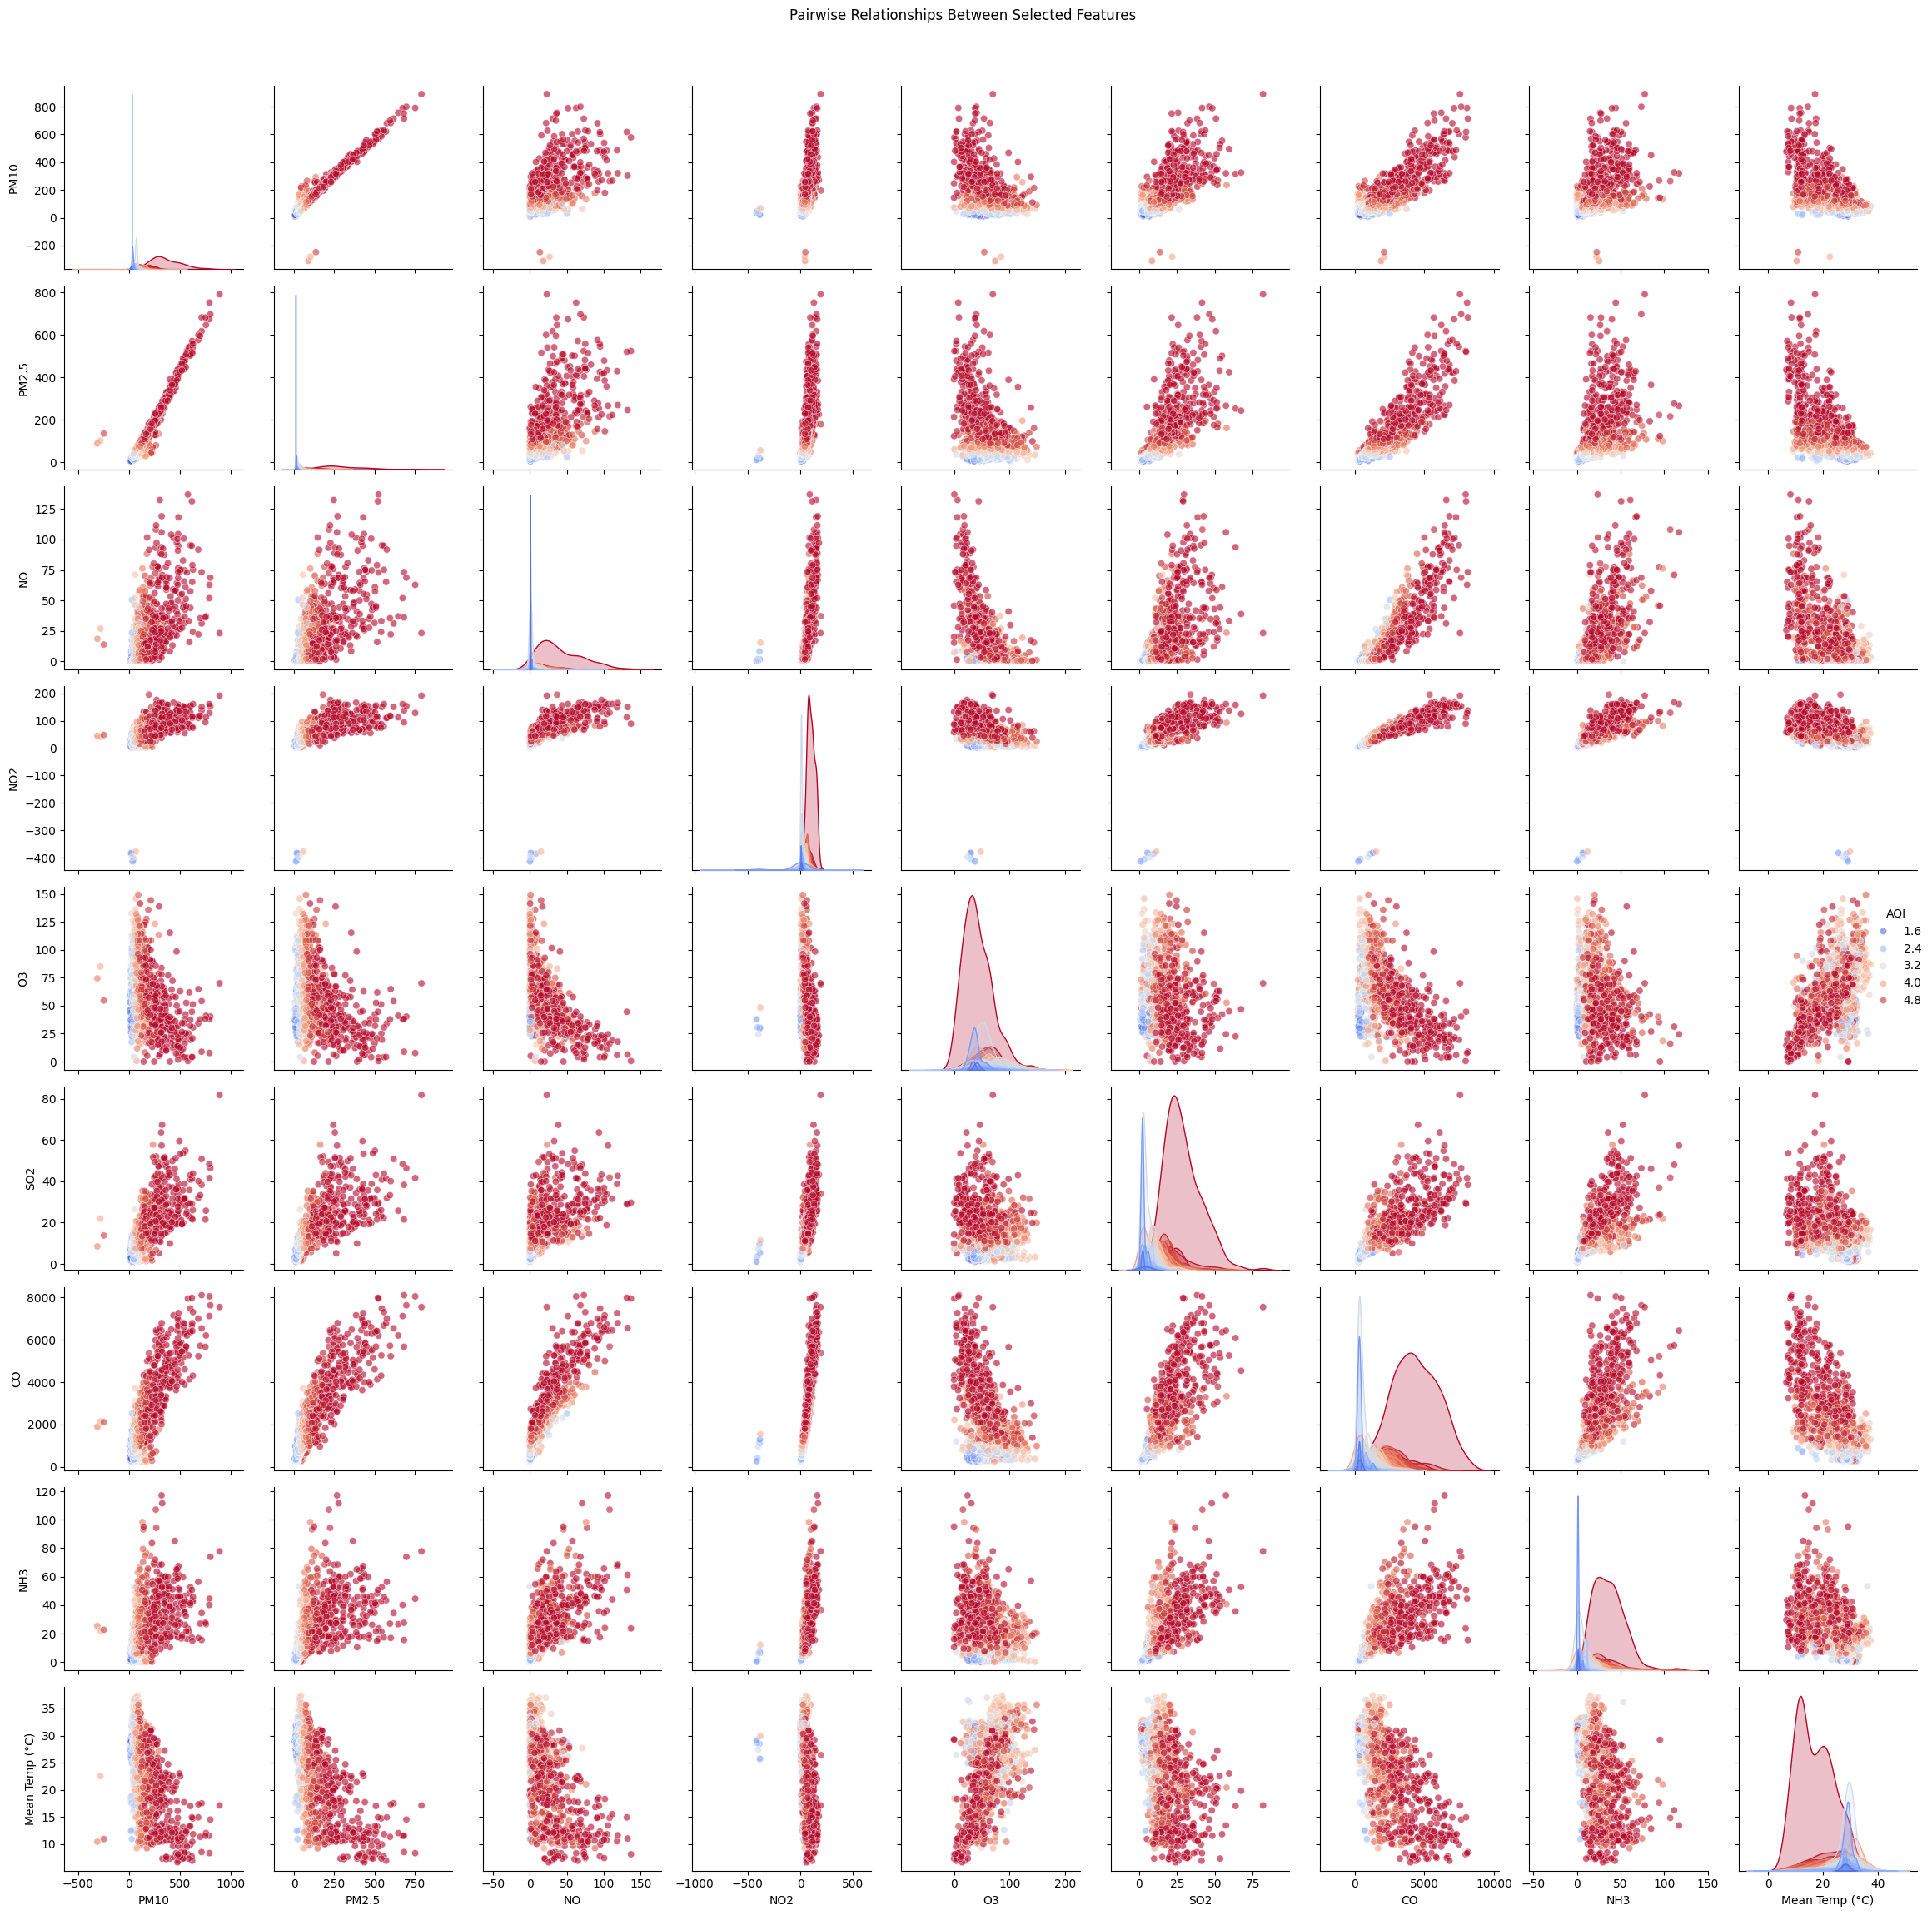

In [14]:
# Select a subset of relevant features for pairplot
features_subset = ['PM10','PM2.5','NO','NO2','O3','SO2','CO','NH3','Mean Temp (°C)','AQI']

# Plot pairwise relationships between selected features
sns.pairplot(df_cleaned[features_subset], kind='scatter', hue='AQI', palette='coolwarm', plot_kws={'alpha':0.6})
plt.suptitle('Pairwise Relationships Between Selected Features', y=1.02)
plt.tight_layout()
plt.show()


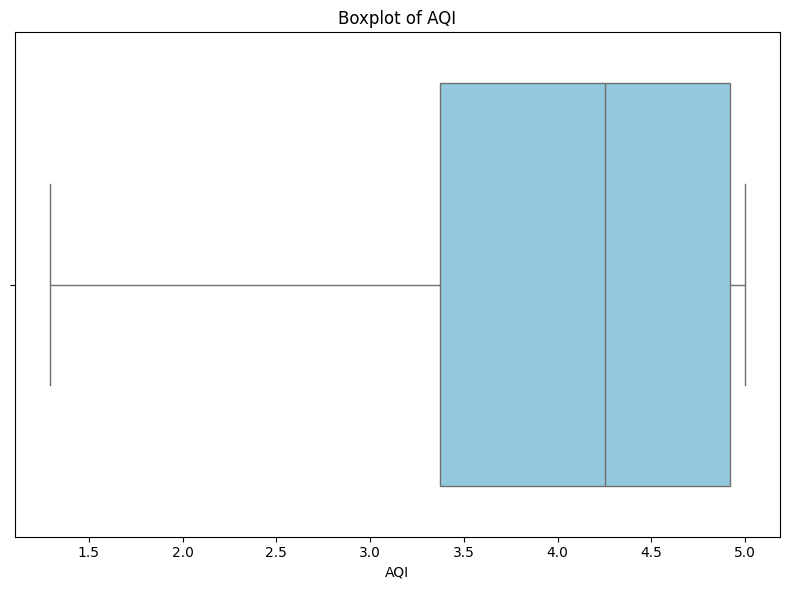

In [15]:
# Boxplot for AQI outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_cleaned['AQI'], color='skyblue')
plt.title('Boxplot of AQI')
plt.xlabel('AQI')
plt.tight_layout()
plt.show()


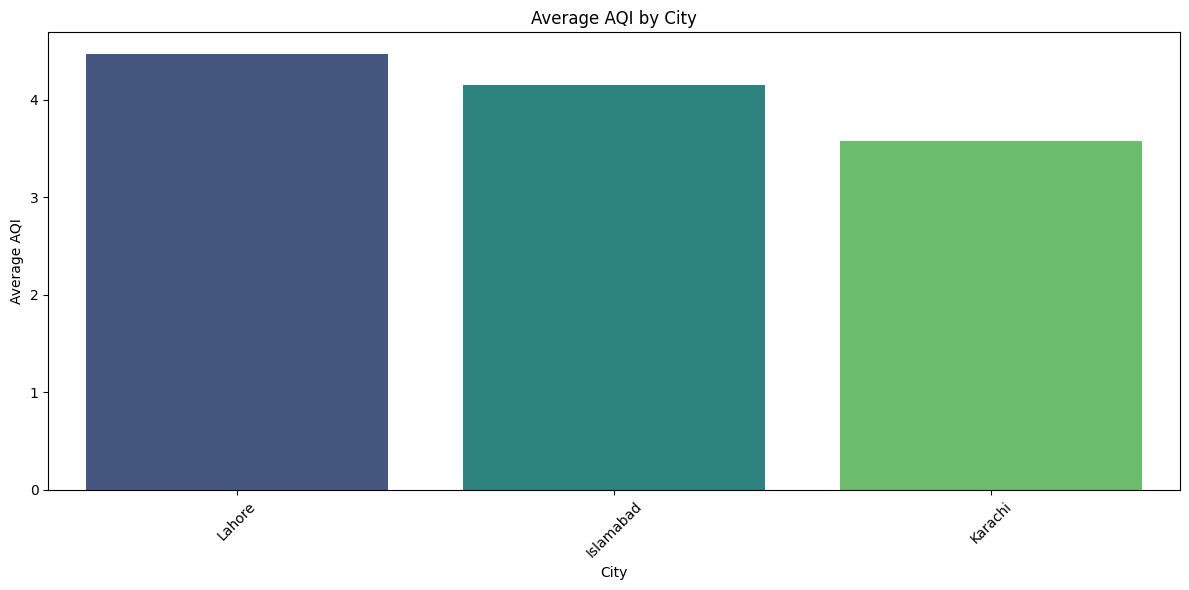

In [16]:
# Calculate the average AQI per city
city_avg_aqi = df_cleaned.groupby('City')['AQI'].mean().sort_values(ascending=False)

# Bar plot for city-wise average AQI
plt.figure(figsize=(12, 6))
sns.barplot(x=city_avg_aqi.index, y=city_avg_aqi.values, palette='viridis')
plt.title('Average AQI by City')
plt.xlabel('City')
plt.ylabel('Average AQI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


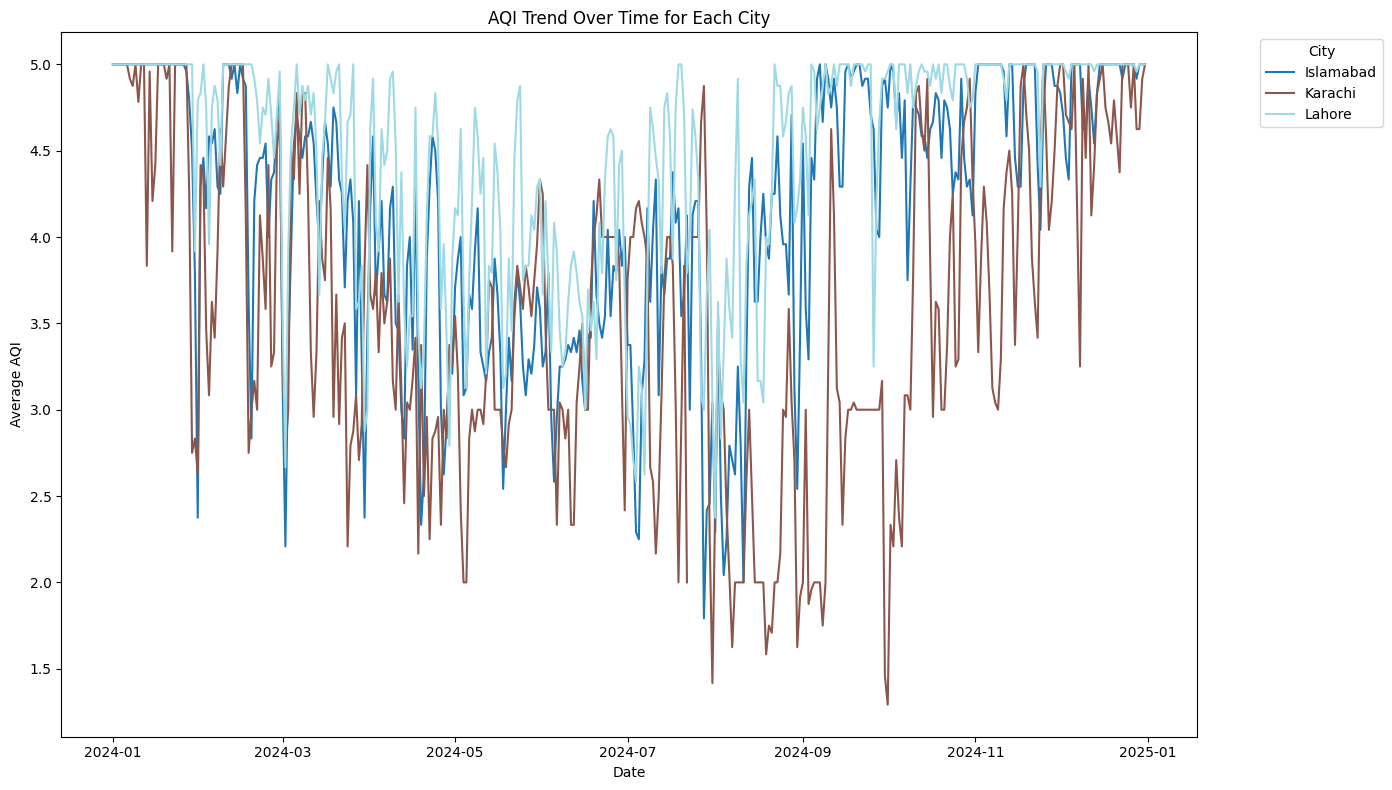

In [17]:
# Set the timestamp column as datetime (if not already)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Group by city and date, and calculate the mean AQI
city_time_series = df_cleaned.groupby([df_cleaned['Date'].dt.date, 'City'])['AQI'].mean().unstack()

# Plot AQI trend over time for each city
city_time_series.plot(figsize=(14, 8), cmap='tab20')
plt.title('AQI Trend Over Time for Each City')
plt.xlabel('Date')
plt.ylabel('Average AQI')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


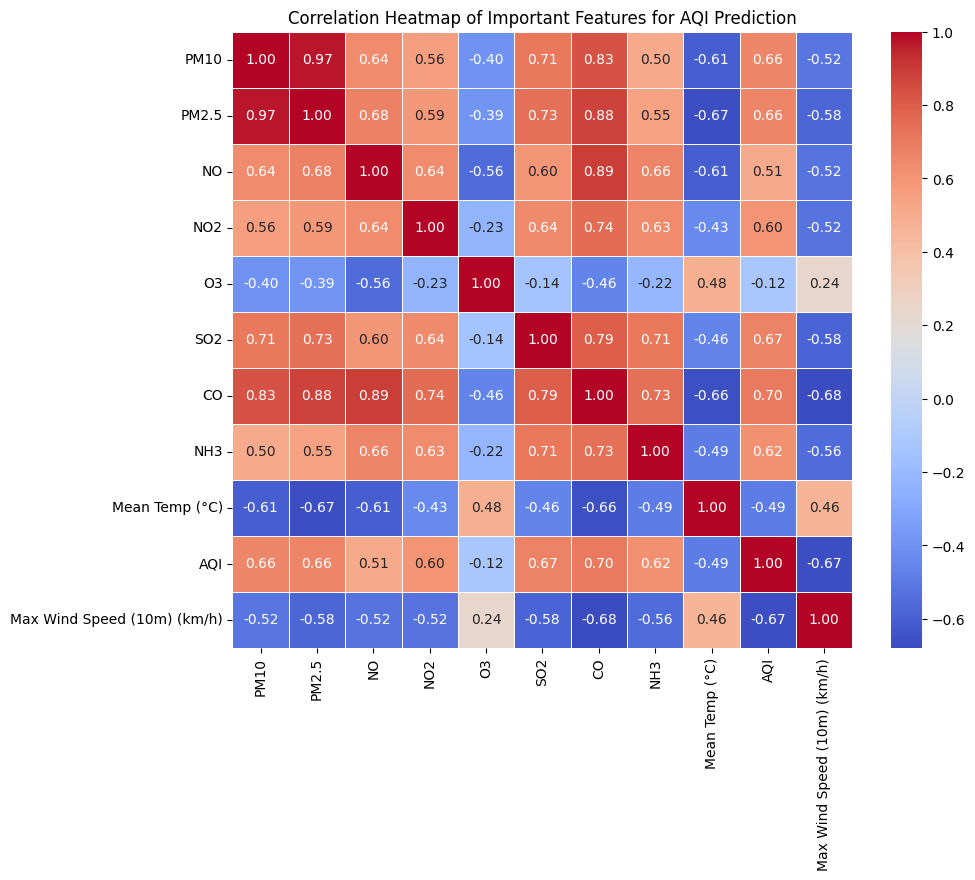

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of important features for AQI prediction
important_features = ['PM10','PM2.5','NO','NO2','O3','SO2','CO','NH3','Mean Temp (°C)','AQI','Max Wind Speed (10m) (km/h)']

# Select relevant features from the cleaned dataset
df_important = df_cleaned[important_features]

# Compute the correlation matrix
corr_matrix = df_important.corr()

# Set up the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the heatmap
plt.title('Correlation Heatmap of Important Features for AQI Prediction')
plt.show()


In [19]:
import pandas as pd
import numpy as np

# Assuming df_cleaned is already available (th
# e cleaned dataset)

# Ensure Date column is in datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')

# --- 1. Seasonal Feature ---
def assign_season(month):
    """Function to assign season based on the month."""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply the function to create the 'Season' feature
df_cleaned['Season'] = df_cleaned['Date'].dt.month.apply(assign_season)

# --- 2. Air Quality Indicator (AQI) Categories ---
def categorize_aqi(aqi):
    """Function to categorize AQI values into different levels (1-5) and return category label."""
    if aqi <= 1:
        return 1, "Good"
    elif aqi <= 2:
        return 2, "Moderate"
    elif aqi <= 3:
        return 3, "Unhealthy for Sensitive Groups"
    elif aqi <= 4:
        return 4, "Unhealthy"
    elif aqi <= 5:
        return 5, "Very Unhealthy"
    else:
        return 5, "Hazardous"

# Apply the function to create both 'AQI_Category' numeric level (1-5) and 'AQI_Label' category label
df_cleaned[['AQI_Category', 'AQI_Label']] = df_cleaned['AQI'].apply(lambda x: pd.Series(categorize_aqi(x)))

# --- Check the changes ---
# Display the first few rows to ensure the new features are added correctly
print(df_cleaned[['Date',  'Season', 'AQI_Category', 'AQI_Label']].head())

# Optionally, check for unique values in the new features
print("\nSeason counts:")
print(df_cleaned['Season'].value_counts())

print("\nAQI Category counts:")
print(df_cleaned['AQI_Category'].value_counts())

print("\nAQI Label counts:")
print(df_cleaned['AQI_Label'].value_counts())


        Date  Season  AQI_Category       AQI_Label
0 2024-01-01  Winter             5  Very Unhealthy
1 2024-01-02  Winter             5  Very Unhealthy
2 2024-01-03  Winter             5  Very Unhealthy
3 2024-01-04  Winter             5  Very Unhealthy
4 2024-01-05  Winter             5  Very Unhealthy

Season counts:
Season
Spring    276
Summer    275
Winter    273
Fall      273
Name: count, dtype: int64

AQI Category counts:
AQI_Category
5    625
4    298
3    141
2     33
Name: count, dtype: int64

AQI Label counts:
AQI_Label
Very Unhealthy                    625
Unhealthy                         298
Unhealthy for Sensitive Groups    141
Moderate                           33
Name: count, dtype: int64


In [20]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming df_cleaned is already loaded and cleaned dataset
# df_cleaned should include features like: 'PM10', 'PM2.5', 'NO2', 'SO2', 'CO', 'O3', 'Mean Temp (°C)', 'Wind Speed', 'Date', 'AQI'

# --- Step 1: Feature Engineering ---
# Selecting relevant features for AQI prediction
features = ['PM10', 'PM2.5', 'NO2', 'SO2', 'CO', 'O3', 'Mean Temp (°C)', 'Max Wind Speed (10m) (km/h)', 'Dominant Wind Direction (°)', 'Shortwave Radiation Sum (MJ/m²)']

# Drop rows where any of the selected features or AQI column is NaN (if applicable)
df_cleaned = df_cleaned.dropna(subset=features + ['AQI'])

# Define the feature matrix X and target variable y
X = df_cleaned[features]
y = df_cleaned['AQI']

# --- Step 2: Split the data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Feature Scaling (Optional) ---
# Scale the features if necessary (RandomForest does not require scaling, but it can help with other models like Linear Regression or SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 4: Train Multiple Models ---

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store evaluation results
model_performance = {}

# Train each model and evaluate its performance
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Train the model
    y_pred = model.predict(X_test_scaled)  # Predict on the test set
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store performance metrics
    model_performance[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# --- Step 5: Display Model Performance ---
# Display the evaluation results for all models
performance_df = pd.DataFrame(model_performance).T
print("Model Evaluation Results:")
print(performance_df)

# --- Step 6: Select the Best Model ---
# Select the model with the best R² score (highest value)
best_model_name = performance_df['R²'].idxmax()
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name} with R² = {performance_df.loc[best_model_name, 'R²']}")

# --- Step 7: Save the Best Model ---
# Save the best model and scaler (if used)
joblib.dump(best_model, f'best_aqi_model_{best_model_name}.joblib')
joblib.dump(scaler, 'scaler_for_best_aqi_model.joblib')  # Save the scaler if used

print(f"\nBest AQI prediction model ({best_model_name}) and scaler have been saved.")

# --- Step 8: Optionally, you can load the saved model and scaler to make predictions in the future ---
# Example: Load the best model and scaler
# loaded_model = joblib.load(f'best_aqi_model_{best_model_name}.joblib')
# loaded_scaler = joblib.load('scaler_for_best_aqi_model.joblib')

# Make predictions using the loaded model
# y_pred_loaded = loaded_model.predict(loaded_scaler.transform(X_test))
# print(f"Predictions using the loaded model: {y_pred_loaded[:5]}")  # Print first 5 predictions


Model Evaluation Results:
                       MAE       MSE      RMSE        R²
RandomForest      0.132593  0.034058  0.184549  0.959394
LinearRegression  0.435174  0.301139  0.548761  0.640972
SVR               0.169554  0.054695  0.233869  0.934791
DecisionTree      0.189690  0.077496  0.278381  0.907607
XGBoost           0.139421  0.037402  0.193396  0.955408
GradientBoosting  0.127418  0.028506  0.168838  0.966014

Best Model: GradientBoosting with R² = 0.9660138538158749

Best AQI prediction model (GradientBoosting) and scaler have been saved.


In [24]:
import pandas as pd
import joblib
import numpy as np

# Step 1: Load the new dataset
new_data_path = 'data\combined_data_20250114.csv'  # Update with the correct path if necessary
new_data = pd.read_csv(new_data_path)

# Step 2: Preprocess the new data
# Ensure the 'Date' column is in datetime format
new_data['Date'] = pd.to_datetime(new_data['Date'], errors='coerce')

# Select relevant features (same as used for training)
features = ['PM10', 'PM2.5', 'NO2', 'SO2', 'CO', 'O3', 'Mean Temp (°C)', 'Max Wind Speed (10m) (km/h)', 'Dominant Wind Direction (°)', 'Shortwave Radiation Sum (MJ/m²)']

# Drop rows with NaN values in the features or AQI column
new_data_clean = new_data.dropna(subset=features)

# Define the feature matrix X for the new data
X_new = new_data_clean[features]

# Step 3: Load the saved model and scaler
best_model_name = 'best_aqi_model_GradientBoosting.joblib'  # Replace with your best model's name if it's different
scaler_name = 'scaler_for_best_aqi_model.joblib'

# Load the model and scaler
best_model = joblib.load(best_model_name)
scaler = joblib.load(scaler_name)

# Step 4: Preprocess the new data (Scaling)
X_new_scaled = scaler.transform(X_new)

# Step 5: Make predictions using the best model
y_pred_new = best_model.predict(X_new_scaled)

# Step 6: Display the predictions
new_data_clean['Predicted_AQI'] = y_pred_new

# Print the first few rows of predictions
print(new_data_clean[['Date', 'Predicted_AQI']].head())

# Optionally, save the predictions to a new CSV file
new_data_clean.to_csv('predictions_20250113.csv', index=False)
print("Predictions have been saved to 'predictions_20250113.csv'.")


        Date  Predicted_AQI
0 2025-01-14       4.875107
1 2025-01-14       4.647839
2 2025-01-14       4.975236
Predictions have been saved to 'predictions_20250113.csv'.


In [26]:
import pandas as pd
import joblib
import numpy as np
from datetime import timedelta

# Step 1: Load the new dataset (same as before)
new_data_path = 'data/combined_data_20250114.csv'  # Update the path if necessary
new_data = pd.read_csv(new_data_path)

# Step 2: Preprocess the new data
# Ensure the 'Date' column is in datetime format
new_data['Date'] = pd.to_datetime(new_data['Date'], errors='coerce')

# Select relevant features (same as used for training)
features = ['PM10', 'PM2.5', 'NO2', 'SO2', 'CO', 'O3', 'Mean Temp (°C)', 'Max Wind Speed (10m) (km/h)', 'Dominant Wind Direction (°)', 'Shortwave Radiation Sum (MJ/m²)']

# Drop rows with NaN values in the features or AQI column
new_data_clean = new_data.dropna(subset=features)

# Step 3: Load the saved model and scaler
best_model_name = 'best_aqi_model_GradientBoosting.joblib'  # Replace with your best model's name
scaler_name = 'scaler_for_best_aqi_model.joblib'

# Load the model and scaler
best_model = joblib.load(best_model_name)
scaler = joblib.load(scaler_name)

# Step 4: Predict AQI for each city
# Group data by 'City'
cities = new_data_clean['City'].unique()

# Create an empty DataFrame to store predictions
all_predictions = []

for city in cities:
    city_data = new_data_clean[new_data_clean['City'] == city]
    
    # Define the feature matrix X for the city's data
    X_city = city_data[features]
    
    # Step 5: Preprocess the city's data (Scaling)
    X_city_scaled = scaler.transform(X_city)
    
    # Step 6: Make predictions for the city's data using the best model
    y_pred_city = best_model.predict(X_city_scaled)
    
    # Step 7: Add the predictions to the city's data
    city_data['Predicted_AQI'] = y_pred_city
    
    # Save the city's predictions to the all_predictions list
    all_predictions.append(city_data[['City', 'Date', 'Predicted_AQI']])

# Combine all city-wise predictions into a single DataFrame
city_predictions_df = pd.concat(all_predictions, axis=0)

# Print the first few rows of predictions
print(city_predictions_df.head())

# Optionally, save the city-wise predictions to a new CSV file
city_predictions_df.to_csv('citywise_predictions_20250114.csv', index=False)
print("City-wise predictions for existing data have been saved.")

# Step 8: Predict for the next 7 days for each city
# Assuming we use the last available row of data for each city
future_predictions = []

for city in cities:
    city_data = new_data_clean[new_data_clean['City'] == city]
    
    # Get the last row of data for the city
    last_row = city_data.iloc[-1]
    
    # Generate new dates for the next 7 days
    future_dates = pd.date_range(start=last_row['Date'] + timedelta(days=1), periods=7).date
    
    # Predict the AQI for the next 7 days for this city
    for future_date in future_dates:
        # Use the last row's feature values for simplicity (extend with forecasting models if needed)
        future_features = last_row[features].values  # Use the last row's values for simplicity
        
        # Reshape the features to match the model input
        future_features_scaled = scaler.transform([future_features])
        
        # Make the prediction for AQI
        future_aqi = best_model.predict(future_features_scaled)
        
        # Store the result with the future date and city
        future_predictions.append({'City': city, 'Date': future_date, 'Predicted_AQI': future_aqi[0]})

# Convert future predictions to a DataFrame
future_predictions_df = pd.DataFrame(future_predictions)

# Print the future predictions for all cities
print(future_predictions_df)

# Optionally, save the future predictions to a new CSV file
future_predictions_df.to_csv('citywise_predictions_next_7_days.csv', index=False)
print("City-wise predictions for the next 7 days have been saved.")


        City       Date  Predicted_AQI
0  Islamabad 2025-01-14       4.875107
1    Karachi 2025-01-14       4.647839
2     Lahore 2025-01-14       4.975236
City-wise predictions for existing data have been saved.
         City        Date  Predicted_AQI
0   Islamabad  2025-01-15       4.875107
1   Islamabad  2025-01-16       4.875107
2   Islamabad  2025-01-17       4.875107
3   Islamabad  2025-01-18       4.875107
4   Islamabad  2025-01-19       4.875107
5   Islamabad  2025-01-20       4.875107
6   Islamabad  2025-01-21       4.875107
7     Karachi  2025-01-15       4.647839
8     Karachi  2025-01-16       4.647839
9     Karachi  2025-01-17       4.647839
10    Karachi  2025-01-18       4.647839
11    Karachi  2025-01-19       4.647839
12    Karachi  2025-01-20       4.647839
13    Karachi  2025-01-21       4.647839
14     Lahore  2025-01-15       4.975236
15     Lahore  2025-01-16       4.975236
16     Lahore  2025-01-17       4.975236
17     Lahore  2025-01-18       4.975236
18     L